# Fake News Detection
Sam Earnest
Alex Johnson

# Introduction and Motivation

A common complaint made by many followers (including many politicians) of contemporary 21st-century U.S. politics is that of "fake" news, that a news article or a news source itself is deliberately producing and divulging news that is knowingly counterfactual. Seeing the supposed frequency of this problem, we, the authors of this project, decided to create a machine learning algorithm that would be able to differentiate between news considered to be true against news considered to be fake. The project that follows is our attempt at the differentiation of interest, highlighted by a Random Forest classification, as well as a Principal Component Analysis (PCA) and Center-Base Clustering method (k-means). We end by running a simple logistic regression.

To accomplish this purpose, we obtained a dataset that contains news articles classified as both true and false between the years 2015 and 2017. The dataset is very likely valid since the data is merely news articles and their accompanying titles. In addition, the dataset was created by an academic source, most likely eliminating most expected bias in the classification of news as true or fake. We note that this dataset is ideally suited to the demands of our project since it contains the classifications of true and false that we are trying to achieve.

We note that this work is done mostly independent of other research that has been done on the matter. We are aware of the existence of other machine learning algorithms that fulfill similar purposes to that of our own, but we looked to develop a unique method that we created. We in no way look to infringe or trespass on their intellectual property or copy their methods. We do borrow the method for the kernel function from another author, as well as borrowing the main idea behind the logistic regression from an independent collaborator, as explained later on.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import nltk

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets

import seaborn as sns

# Data Preparation and Cleaning

The data for this project came from kaggle.com, published by Clément Bisaillon for open source use, and is a collection of fake and true news articles from 2016 to 2018 used in an academic study. In this section, we clean our data by removing stop words, non-English words, and limit the amount of words to the most frequent 500. We remove stop words and non-English words since we believe they will not be relevant in determining if an article contains true or fake news. We limit ourselves to the 500 most fequent words to aid in computational time and feel that 500 is a good threshold of relevance.

In [125]:
#Upload datasets and create true column
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')
df_fake['true'] = 0
df_true['true'] = 1
df = pd.concat([df_fake, df_true])
df[:5]

,title,text,subject,date,true
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


First we need to identify all of the potential words in our dataset. We throw out all stop words, numbers, and non-alphabetic charaters. The top 500 most frequent words become the columns for our dataframe. This is done using regular expressions.

In [5]:
wrds = {}
stop_words = set(stopwords.words('english'))
#Set up tokenizer to only grab ASCII characters
tokenizer = nltk.RegexpTokenizer(r"\w+")

for index, row in df.iterrows():
    text = row['text'].lower()
    #Filter for stop words
    text = re.sub(r'\d+', '', text)
    word_tokens = tokenizer.tokenize(text)
    filtered_text = [w for w in word_tokens if not w in stop_words]
    
    #Go through each sig word in text and add frequency to dictionary of words
    for word in filtered_text:
        if '_' in word:
            continue
        if word in wrds:
            wrds[word] = wrds[word] + 1
        else:
            wrds[word] = 1 

wrds = sorted(wrds, key=wrds.get, reverse=True)

In [124]:
#Create columns using the 500 top words a column names
master_df = pd.DataFrame(0, index= df.index, columns = wrds[:500])

Now we add the frequency of each word to its associated document and divide the frequency by the total number of words in the document. This gives us relative weights of each word for each document. This will also allow us to make a more fair comparison between words as the documents in our dataset vary in length, or total amount of words.

In [7]:
for index, row in df.iterrows():
    text = row['text'].lower()
    #Filter for stop words
    text = re.sub(r'\d+', '', text)
    word_tokens = tokenizer.tokenize(text)
    filtered_text = [w for w in word_tokens if not w in stop_words]
    num_words = len(text.split())
    
    for word in filtered_text:
        if word in wrds[:500]:
            master_df.loc[index, word] = master_df.loc[index, word] + 1
            
    master_df.loc[index] = master_df.loc[index].div(num_words)

In [122]:
#Save data frame to avoid computational time
#master_df.to_csv('500matrix_weighted.csv')
master_df = pd.read_csv('500matrix.csv', index_col=0)
#Move truth column to be the first column

truth = master_df.pop('true')
master_df.insert(0,'true',truth)

df_true = master_df[master_df['true']==1]
df_false = master_df[master_df['true']==0]
master_df[:5]

,true,trump,said,president,would,u,people,one,state,also,...,paul,authorities,bush,front,candidates,december,position,rule,army,capital
0,0,16,8,5,5,4,4,3,0,4,...,1,0,0,0,0,15,0,0,0,0
1,0,16,12,6,6,2,2,2,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,15,8,2,1,1,4,1,0,0,...,0,0,0,0,0,14,0,0,0,0
3,0,21,3,3,4,2,2,0,0,3,...,0,0,0,0,0,8,0,0,0,0
4,0,10,12,5,1,4,1,1,0,2,...,0,0,0,0,0,0,0,0,0,1


<AxesSubplot:title={'center':'Top 25 Word Frequency'}, xlabel='Word', ylabel='Frequency'>

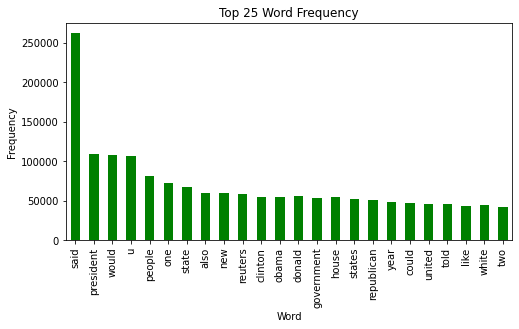

In [20]:
df_non = pd.read_csv('500matrix.csv', index_col=0)
df_non.sum(axis=0)[1:25].plot.bar(figsize=(8,4), title='Top 25 Word Frequency', ylabel='Frequency', xlabel='Word', color='green')

As can be seen from the bar chart the word "trump" is by far the most frequent word in our set. Other common words include "said", "president", and "would". This being said, we note that words such as "said" and "would" may not be very telling of fake or true news as they are very common in the English vernacular. We note interestingly words like "clinton", "reuters", and "government" also have high frequencies. From what is shown, there appear to be many words of marked interest that have higher frequencies that will be the subject of further study in the analysis that follows.

Immediately, we include several histograms of a few of these words that emit higher levels of interest.

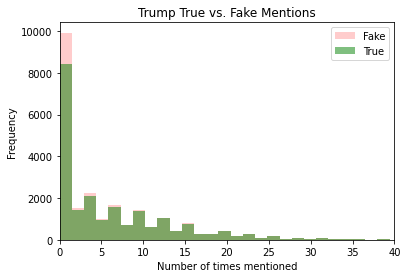

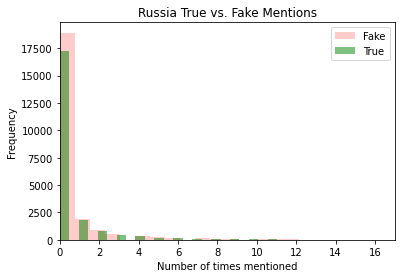

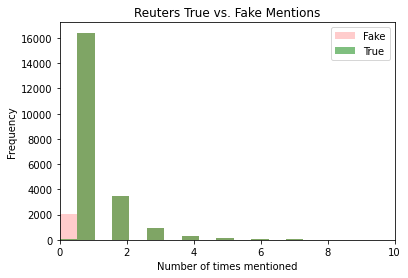

In [22]:
#Histogram 1: Trump
plt.hist(df_non[df_non["true"]==0]["trump"],alpha=0.2,bins=50,color="red",label="Fake")
plt.hist(df_non[df_non["true"]==1]["trump"],alpha=0.5,bins=50,color="green",label="True")
plt.title("Trump True vs. Fake Mentions")
plt.xlabel("Number of times mentioned")
plt.ylabel("Frequency")
plt.xlim(0,40)
plt.legend()
plt.show()

#Histogram 2: Russia
plt.hist(df_non[df_non["true"]==0]["russia"],alpha=0.2,bins=50,color="red",label="Fake")
plt.hist(df_non[df_non["true"]==1]["russia"],alpha=0.5,bins=50,color="green",label="True")
plt.title("Russia True vs. Fake Mentions")
plt.xlabel("Number of times mentioned")
plt.ylabel("Frequency")
plt.xlim(0,17)
plt.legend()
plt.show()

#Histogram 3: Reuters
plt.hist(df_non[df_non["true"]==0]["reuters"],alpha=0.2,bins=50,color="red",label="Fake")
plt.hist(df_non[df_non["true"]==1]["reuters"],alpha=0.5,bins=50,color="green",label="True")
plt.title("Reuters True vs. Fake Mentions")
plt.xlabel("Number of times mentioned")
plt.ylabel("Frequency")
plt.xlim(0,10)
plt.legend()
plt.show()

Two of the words that we initially hypothesize to be indicators of fake news are the words "trump" and "russia" from the controversies that these two political figures were involved in in the years 2015-2017 (the year from which our data comes from). To check for this, we plot the overlayed histograms of fake news against true news for "trump" and "russia". Notice that for both "trump" and "russia", the frequency of number of mentions between 0 and 5 is high for both fake and true news, which seems to confirm our early interest. Moreover, in the same number of mentions category, it is evident that fake mentions for both "trump" and "russia" have a higher frequency than their true counterparts, showing that these words are perhaps strong indicators of fake news. 

We then compare these two words to the word "reuters" (a international news outlet based in Germany), which we hypothesize to be a control against "trump" and "russia". Upon first observation of the similarly overlayed histogram, it is clear that "reuters" is indeed a strong control, since there are very few fake news mentions of this word, compared to many true news mentions (which are likely the articles put out by the the company in interest). 

These observations from the visualizations are impressively telling and are consistent with our expectations on the matter. We run more tests to further solidify these expectations in what follows.

Now we format the data as y and X and split between train and test sets. We use a fairly small training set of 2,244 articles randomly selected for computational purposes

In [121]:
data = master_df.to_numpy()
y = data[:,0]
X = data[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.98)

# Feature Engineering (Kernel Function)

Now we define our kerneling method. We chose to use the document similarity kernel as opposed to the cosine similarity kernel because we're dealing with documents and this kernel should give better results. 

In [53]:
def tf(x):
    return np.log(1+x)

def idf(j):
    return np.log(j.size/(1+np.count_nonzero(j)))

def phi(x, idf):
    result = np.zeros(len(idf))
    for i in range(0,len(idf)):
        result[i] = x[i]*idf[i]
    return result

def doc_sim(M):
    #Apply tf to each element in M
    M = np.vectorize(tf)(M)
    #Create the inverse document frequency array- one value for each word
    idf_v = np.zeros(M.shape[1])
    for j in range (0,M.shape[1]):
        idf_v[j] = idf(M[:,j]) 

    #Create kernel matrix and fill it 
    K = np.zeros((M.shape[0], M.shape[0]))
    for i in range(0, K.shape[0]):
        #print(i)
        for j in range(0, K.shape[1]):
            phi_x = phi(M[i,:], idf_v)
            phi_y = phi(M[j,:], idf_v)
            K[i,j] = (np.transpose(phi_x)@phi_y)/(np.linalg.norm(phi_x)*np.linalg.norm(phi_y))

    return K


In [54]:
K = doc_sim(X_train)

<ipython-input-53-7047c03129a5>:28: RuntimeWarning: invalid value encountered in double_scalars
  K[i,j] = (np.transpose(phi_x)@phi_y)/(np.linalg.norm(phi_x)*np.linalg.norm(phi_y))


In [55]:
np.save('K_800', K)

In [56]:
k = np.load("K_800.npy")
l = np.argwhere(np.isnan(k))
#k = np.nan_to_num(np.inf)
k[np.isnan(k)] = 0

# Principal Component Analysis (PCA)

The first classification technique we employ is PCA. We first run through the algorithm without having passed the training data through the kernel function, after which we attempt the same strategy after having put the data in the kernel function.

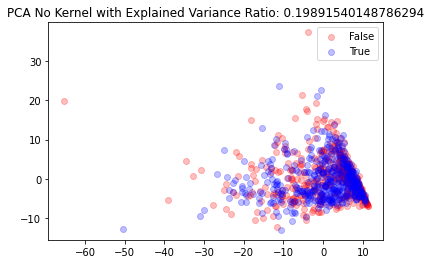

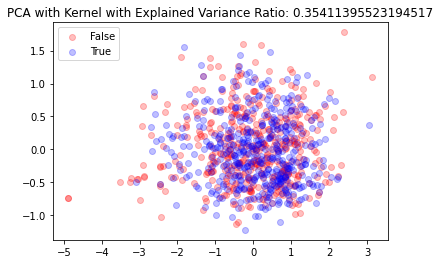

In [57]:
#First with no kernel
X = X_train
X[np.isnan(X)] = 0
y = y_train
pca = PCA(n_components=5)
Xhat_1 = pca.fit_transform(X)

var = pca.explained_variance_ratio_
var = var[0]+var[1]

f = Xhat_1[y_train==0]
t = Xhat_1[y_train==1]
f_plt = plt.scatter(f[:,0]*-1, f[:,1], color = 'red', alpha=0.25)
t_plt = plt.scatter(t[:,0]*-1, t[:,1], color = 'blue',alpha=0.25)
plt.legend([f_plt, t_plt], ['False', 'True'])
plt.title("PCA No Kernel with Explained Variance Ratio: " + str(var) )
plt.show()

#Now with kernel
X = k
y = y_train
pca = PCA(n_components=5)
Xhat = pca.fit_transform(X)

var = pca.explained_variance_ratio_
var = var[0]+var[1]

f = Xhat[y_train==0]
t = Xhat[y_train==1]
f_plt = plt.scatter(f[:,0]*-1, f[:,1], color = 'red', alpha=0.25)
t_plt = plt.scatter(t[:,0]*-1, t[:,1], color = 'blue',alpha=0.25)
plt.legend([f_plt, t_plt], ['False', 'True'])
plt.title("PCA with Kernel with Explained Variance Ratio: " + str(var) )
plt.show()

As you can see both methods fail to seperate the data in any meaningful way. This being said, the PCA on the kernel data is certainly more spread out and slightly better than that on the non-kernel data, as is apparent in their variances. We now move onto a Random Forest classification to see if that method allows us to more accurately classify our data.

# Random Forest Classification

Here we use the Random Forest method as a prediction tool to classify between true and fake news. Notice that we run two separate Random Forest classifications, which we do to find the "best" (or most predictive) 100 features.

In [58]:
rf = RandomForestClassifier(criterion="entropy")
rf.fit(Xhat_1,y_train)
# rf.predict(X_train,y_train)

param_grid = {"n_estimators": [100,200,300], "max_depth": [10,25,50,75], "min_samples_leaf": [10,5,2]}
rf_gs = GridSearchCV(rf, param_grid, scoring="f1", n_jobs=-1)
rf_gs.fit(Xhat_1,y_train)
print(rf_gs.best_params_, rf_gs.best_score_, sep='\n')

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 300}
0.5784143807999435


In [59]:
result = RandomForestClassifier(oob_score=True, max_depth=10, n_estimators=300, min_samples_leaf=2).fit(X_train,y_train)
importances = result.feature_importances_

In [118]:
importances1 = importances.argsort()[-100:][::-1]
importances1_list = importances1.tolist()

After having found the most predictive 100 features, we now create a new dataframe (referred to as new_df in the code) that is solely based on these 100 features. Once this dataframe has been created, we run a PCA again, and we then run the Random Forest classification again. Our analysis will follow.

In [119]:
new_df = master_df.iloc[:,importances1_list]
col_name="true"
first_col = new_df.pop(col_name)
new_df.insert(0, col_name, first_col)

data1 = new_df.to_numpy()
y = data1[:,0]
X = data1[:,1:]
X[np.isnan(X)] = 0

rfX_train, rfX_test, rfy_train, rfy_test = train_test_split(X, y, test_size=0.98)

pca = PCA(n_components=99)
rfXhat_1 = pca.fit_transform(rfX_train)

In [63]:
rf1 = RandomForestClassifier(criterion="entropy")
rf1.fit(rfXhat_1,rfy_train)

param_grid = {"n_estimators": [100,200,300], "max_depth": [10,25,50,75], "min_samples_leaf": [10,5,2]}
rf1_gs = GridSearchCV(rf1, param_grid, n_jobs=-1)
rf1_gs.fit(rfXhat_1,rfy_train)
print(rf1_gs.best_params_, rf1_gs.best_score_, sep='\n')

{'max_depth': 25, 'min_samples_leaf': 2, 'n_estimators': 200}
0.531818746120422


              precision    recall  f1-score   support

           0       0.52      0.96      0.68     23028
           1       0.50      0.04      0.08     20973

    accuracy                           0.52     44001
   macro avg       0.51      0.50      0.38     44001
weighted avg       0.51      0.52      0.39     44001



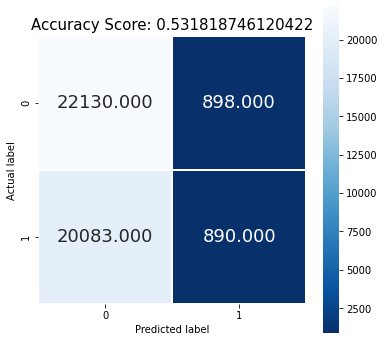

In [120]:
rfX_test[np.isnan(rfX_test)] = 0
result = rf1_gs.best_estimator_.predict(rfX_test)
CM = confusion_matrix(rfy_test,result)
CR = classification_report(rfy_test, result)


plt.figure(figsize=(6,6))
sns.heatmap(CM, annot=True, fmt=".3f", linewidths=0.5, square = True, cmap = 'Blues_r', annot_kws={"size": 18});
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

all_sample_title = 'Accuracy Score: {0}'.format(rf1_gs.best_score_)
plt.title(all_sample_title, size = 15);

print(CR)

As can be seen, our Random Forest classification approach does not necessarily yield the accuracy that was initially desired. In other words, this prediction method does not classify news as true or fake with a very high accuracy, with the best score being approximately 53%. 

With this being said, it is entirely possible that Random Forest classification was not the ideal prediction method for a problem of this type. It may be more useful in future versions of projects of this type to run a pipeline to help us decide which prediction method and which hyperparameters would be the best to pursue. Also, we may benefit from expanding our training dataset. From this, we now move on to a k-means clustering to see if the method is more effective at classifying news as true or fake.

# Clustering and Visualization (K-means)

Here, we run a k-means algorithm (Lloyd's) in an attempt to separate our datasets into two separate, identifiable clusters on the kernel matrix k.

In [66]:
kmeans = KMeans(n_clusters=2,init="random",algorithm="full", random_state=random.randint(0,100))

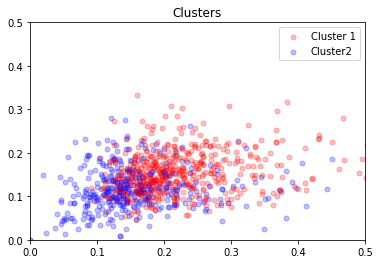

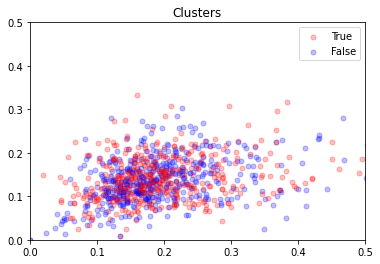

In [67]:
#Actual clustering
x_1 = kmeans.fit_predict(k)

fig, ax = plt.subplots()
for i in range(0, len(x_1)):
    if x_1[i] == 1:
      color = 'red'
      label = 'True'
    else:
      color = 'blue'
      label = 'False'
    ax.scatter(k[i,0], k[i,1], c = color, s = 25,alpha=0.25)
leg = ax.legend(['Cluster 1', 'Cluster2'])
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')
plt.title("Clusters")
plt.xlim(0,0.5)
plt.ylim(0,0.5)

plt.show()
#kmeans.cluster_centers_

x_1 = kmeans.fit_predict(k)

fig, ax = plt.subplots()
for i in range(0, len(x_1)):
    if  y_train[i] == 1:
      color = 'red'
      label = 'True'
    else:
      color = 'blue'
      label = 'False'
    ax.scatter(k[i,0], k[i,1], c = color, s = 25,alpha=0.25)
leg = ax.legend(['True', 'False'])
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')
plt.title("Clusters")
plt.xlim(0,0.5)
plt.ylim(0,0.5)

plt.show()

As can be seen on the scatter plot above, our method has led to the development of two somewhat unique clusters from our training set. After K has been formatted correctly, we then use the KMeans function to develop our clusters. We then use the scatterplot function to visualize the data as seen.

We note that the two clusters are somewhat unique and the clustering is by no means perfect. In the visualization, the blue-colored dots represent news that is being classified as fake, whereas the red-colored dots represent news that is being classified as true. Please observe that there is significant overlap between the two colors, indicating that the clustering method is not ideal. While the k-means algorithm did find two generally unique clusters, these clusters were not accurately classifying true and fake data points.

Obviously the results thus far do not achive the accuracy that we want. Feeling unsatisfied by our results we searched on the internet and found that logistic regression can be a good way to classify documents.

# Logistic Regression

In this section, we run a logistic regression using a document classification technique suggested by Venkatesh Tripathi on kaggle.com. This time we do not separate the data into indivdual words ourselves but instead use a term frequency inverse document frequency (TF-IDF) method to generate the features in our dataset. We begin by again reading in the data and cleaning it in the same manor as before.

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [88]:
#Upload datasets and create true column
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')
df_fake['true'] = 0
df_true['true'] = 1
df = pd.concat([df_fake, df_true])
df

stop_words = set(stopwords.words('english'))
#Set up tokenizer to only grab ASCII characters
tokenizer = nltk.RegexpTokenizer(r"\w+")

for index, row in df.iterrows():
    text = row['text'].lower()
    #Filter for stop words
    text = re.sub(r'\d+', '', text)
    word_tokens = tokenizer.tokenize(text)
    filtered_text = [w for w in word_tokens if not w in stop_words]
    df.iloc[index]['text'] = filtered_text
    
df[['text','true']]

<ipython-input-88-d0fbd445e6d8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[index]['text'] = filtered_text


,text,true
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",1
21414,MINSK (Reuters) - In the shadow of disused Sov...,1
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [77]:
#Split into traing and test data
x = df['text']
y = df['true']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In order to use the text strings for the regression we need to convert them to a vector. The TfidVectorizer method in sklearn takes raw strings and converts them into a matrix of TF-IDF features. This is simlar to what we did before but is much quicker to run.

In [93]:
vectorizer = TfidfVectorizer()
xv_train = vectorizer.fit_transform(x_train)
xv_test=vectorizer.transform(x_test)

And now we run the logistic regression:

In [99]:
LR=LogisticRegression()
LR.fit(xv_train,y_train)
pred=LR.predict(xv_test)
score = LR.score(xv_test,y_test)

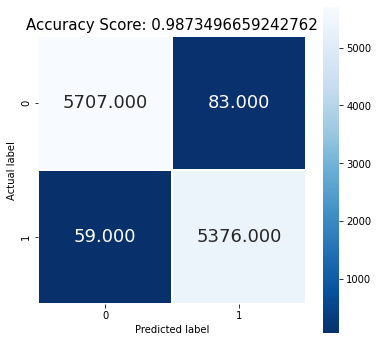

In [117]:
cm = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=0.5, square = True, cmap = 'Blues_r', annot_kws={"size": 18});
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

From the logistic regression, we achieve almost 99% accuracy when classifying our test data. Above we printed out a confusion matrix to give a better break down of the true positives and true negatives. As you can see, 5707 documents were accurately predict false and 5376 were accurately perdicted true. These are encouraging results as to the efficacy of being able to classify true and fake news.

We do note that logistic regression can be susceptible to overfitting the data (since it will always minimize the sum of squared residuals). It is possible that if we run this logistic regression on data that comes outside of our dataset that the results will no longer be so accurate.

# Conclusion

We conclude that logistic regression is the best method for separating fake news from true news. We believe this is because logistic regression is a supervised learning method and the k-means and PCA methods are unsupervised. In the case of the Random Forest classification, we feel the logistic regression was more successful because we used significantly more data on the logistic regression than on the Random Forest. We did not use all the data on the Random Forest classification due to time constraints and computational costs; we invite the interested party to increase the data used in the Random Forest classification to see if accuracy is improved.

## Ethics

In a quick note on ethics, if this fake news detection project were to actually be used it would be important to continuously retrain the model and update its features. News is something that can change drastically from year to year and judging fake news today based off the 2015-2017 news cycle might not be accurate. As mentioned above, the logistic regression could be overfitting the model to our dataset, which may lead to inaccurate results with more current data. If a false sense of trust was put in the algorithm, and it wasn't updated frequently, it could potentially prevent individuals from reading true and important information or feed them false information. 